In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    compress_repeated_epochs,
)
from ripple_heterogeneity.place_cells import place_cells_run, fields, maps
import statistics
import nelpy as nel
from scipy.ndimage import gaussian_filter
from scipy.ndimage import rotate
import pickle
import glob
from skimage import measure
from itertools import chain



<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [31]:

basepath = r"X:\data\Barrage\NN8\day10"
# load position
position_df = loading.load_animal_behavior(basepath)
position_df_no_nan = position_df.query("not x.isnull() & not y.isnull()")

st,cm = loading.load_spikes(basepath)

pos = nel.PositionArray(
    data=position_df_no_nan[["x", "y"]].values.T,
    timestamps=position_df_no_nan.timestamps.values,
)
epoch_df = loading.load_epoch(basepath)
beh_epochs = nel.EpochArray(np.array([epoch_df.startTime,epoch_df.stopTime]).T)

# tc = maps.SpatialMap(pos[epochs[4]],st[epochs[4]],dim=2)
epoch_df


,name,startTime,stopTime,environment,behavioralParadigm
0,presleep_221227_091303,0.0000,7297.90715,sleep,NaN
1,openfield_221227_111500,7297.9072,7620.00635,box,NaN
2,training_221227_112121,7620.0064,7926.96955,box,social memory
3,training2_221227_112649,7926.9696,8227.70555,box,social memory
4,postsleep_221227_115143,8227.7056,16350.89275,sleep,NaN
5,test_221227_141229,16350.8928,16935.66075,box,social memory
6,presleep2_221227_143600,16935.6608,20958.59195,sleep,NaN
7,training2_221227_154326,20958.5920,22200.91515,tmaze,NaN
8,postsleep2_221227_160650,22200.9152,28371.39835,sleep,NaN


In [98]:
ratemaps = []
occupancy = []
meta_df = pd.DataFrame()
epoch_n = 0
for ep, name, environment in zip(
    beh_epochs, epoch_df.name.values, epoch_df.environment.values
):
    if "sleep" in environment:
        continue

    spatial_maps = maps.SpatialMap(
        pos[ep],
        st[ep],
        dim=2,
        s_binsize=3,
        tuning_curve_sigma=3,
        place_field_min_size=15,
        place_field_max_size=1000,
        place_field_sigma=3
    )
    spatial_maps.find_fields()
    ratemaps.append(spatial_maps.tc.ratemap)
    occupancy.append([spatial_maps.tc.occupancy for _ in range(len(spatial_maps.tc.ratemap))])

    meta_df_ = cm[["UID","brainRegion","putativeCellType"]].copy()
    meta_df_["name"] = name
    meta_df_["environment"] = environment
    meta_df_["epoch_n"] = epoch_n
    meta_df_["epoch_duration"] = ep.duration
    meta_df_["epoch_start"] = ep.start
    meta_df_["epoch_stop"] = ep.stop
    meta_df_["spatial_information"] = spatial_maps.tc.spatial_information().tolist()
    meta_df_["spatial_information_pvalues"] = spatial_maps.shuffle_spatial_information().tolist()
    meta_df_["spatial_sparsity"] = spatial_maps.tc.spatial_sparsity().tolist()
    meta_df_["field_n"] = spatial_maps.tc.n_fields.tolist()
    meta_df_["field_size"] = spatial_maps.tc.field_width.tolist()
    meta_df_["field_peak"] = spatial_maps.tc.field_peak_rate.tolist()
    meta_df_["peak_rate"] = spatial_maps.tc.max(axis=1)
    meta_df_["mean_rate"] = spatial_maps.tc.mean(axis=1)

    epoch_n += 1 
    meta_df = pd.concat([meta_df, meta_df_], ignore_index=True)
    
ratemaps = np.array(list(chain.from_iterable(ratemaps)))
occupancy = np.array(list(chain.from_iterable(occupancy)))


In [99]:
meta_df

,UID,brainRegion,putativeCellType,name,environment,epoch_n,epoch_duration,epoch_start,epoch_stop,spatial_information,spatial_information_pvalues,spatial_sparsity,field_n,field_size,field_peak,peak_rate,mean_rate
0,1,CA2so,Pyramidal Cell,openfield_221227_111500,box,0,322.09915,7297.9072,7620.00635,3.027771,0.988024,8.636192,0,NaN,NaN,2.339889,0.115792
1,2,CA2so,Wide Interneuron,openfield_221227_111500,box,0,322.09915,7297.9072,7620.00635,0.588339,0.998004,0.318458,2,49.929951,10.819455,10.819455,3.140131
2,3,CA2so,Pyramidal Cell,openfield_221227_111500,box,0,322.09915,7297.9072,7620.00635,2.882209,0.816367,24.435105,0,NaN,NaN,1.437918,0.040925
3,4,CA2so,Pyramidal Cell,openfield_221227_111500,box,0,322.09915,7297.9072,7620.00635,1.807063,0.946108,1.592803,0,NaN,NaN,6.913516,0.627824
4,5,CA2so,Narrow Interneuron,openfield_221227_111500,box,0,322.09915,7297.9072,7620.00635,0.573166,0.996008,0.189497,0,NaN,NaN,19.742764,5.277131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,44,CA2sp,Pyramidal Cell,training2_221227_154326,tmaze,4,1242.32315,20958.5920,22200.91515,1.877267,0.433134,50.292976,0,NaN,NaN,0.323928,0.019883
236,45,CA1sr,Pyramidal Cell,training2_221227_154326,tmaze,4,1242.32315,20958.5920,22200.91515,1.121498,0.225549,8.060780,0,NaN,NaN,1.191122,0.124057
237,46,CA2so,Pyramidal Cell,training2_221227_154326,tmaze,4,1242.32315,20958.5920,22200.91515,0.701883,0.564870,1.461493,0,NaN,NaN,3.575154,0.684232
238,47,CA2so,Pyramidal Cell,training2_221227_154326,tmaze,4,1242.32315,20958.5920,22200.91515,0.405891,0.754491,0.543933,1,19.209373,6.565931,6.565931,1.838463


In [100]:
from scipy.io import savemat

firingRateMap = {}

firingRateMap["df"] = {name: col.values for name, col in meta_df.items()}
firingRateMap["ratemaps"] = ratemaps
firingRateMap["occupancy"] = occupancy

savemat(
    os.path.join(
        basepath, os.path.basename(basepath) + ".ratemaps.mat"
    ),
    {"firingRateMap": firingRateMap},
)

<AxesSubplot:>

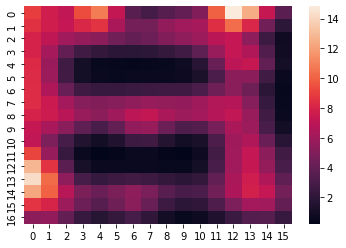

In [44]:
sns.heatmap(ratemaps[meta_df.env_label=="tmaze"][1])